# Evaluate the pancancer
Here I just want to see if the pancancer data is correct and reproduce the results from the EMOGI paper.

In [1]:
from graphdriver import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graphdriver.load import pancancer
from graphdriver.utils import config, constants

In [3]:
# logger.setLevel(logging.DEBUG)
cancer = constants.PANCANCER
conf = config.Conf(cancer)
conf.gcnk = 0
logger = logging.getLogger()
# make use_gtex explicit
conf.use_gtex = True
pc_gtex = pancancer.Pancancer(conf)
pc_gtex.load_all() 
conf.use_gtex = False
pc_tcga = pancancer.Pancancer(conf)
pc_tcga.load_all() 

In [4]:
# dataframes for tcga normal, tumor and gtex
tumor_expr = pd.DataFrame([i.median(axis=1) for i in pc_gtex.tumors_fpkm], index=[i[1] for i in pc_gtex.tissue_types[:]]).T
gtex_expr = pd.DataFrame([i.median(axis=1) for i in pc_gtex.normals_fpkm], index=[i[1] for i in pc_gtex.tissue_types[:]]).T
normal_expr = pd.DataFrame([i.median(axis=1) for i in pc_tcga.normals_fpkm], index=[i[1] for i in pc_tcga.tissue_types[:]]).T

# make it a nice format for barplots in seaborn
tumor_expr['Type'] = 'Tumor'
normal_expr['Type'] = 'Normal (TCGA)'
gtex_expr['Type'] = 'Normal (GTEx)'
all_expr = pd.concat((tumor_expr, normal_expr, gtex_expr), axis=0)
all_expr['Name'] = all_expr.index
all_expr_long = pd.melt(all_expr, id_vars=['Type', 'Name'])

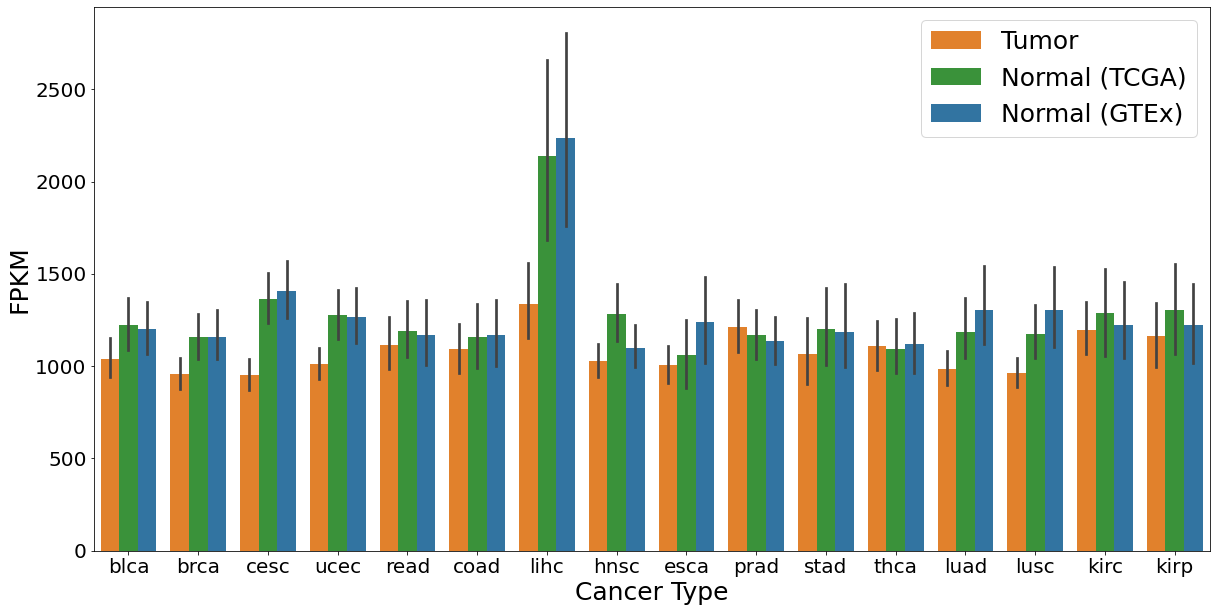

In [5]:
logger.setLevel(logging.WARNING)
fig = plt.figure(figsize=(20, 10))
gene_name = None
data = all_expr_long[all_expr_long.Name == gene_name] if not gene_name is None else all_expr_long
g = sns.barplot(data=data, x='variable', y='value', hue='Type',
            hue_order=['Tumor', 'Normal (TCGA)', 'Normal (GTEx)'],
            palette={'Tumor': 'C1', 'Normal (TCGA)': 'C2', 'Normal (GTEx)': 'C0'})
g.tick_params(labelsize=20)
g.set_xlabel('Cancer Type', fontsize=25)
g.set_ylabel('FPKM', fontsize=25)
#g.set_yscale('log')
plt.title(gene_name, fontsize=30)
plt.legend(prop={'size': 25})

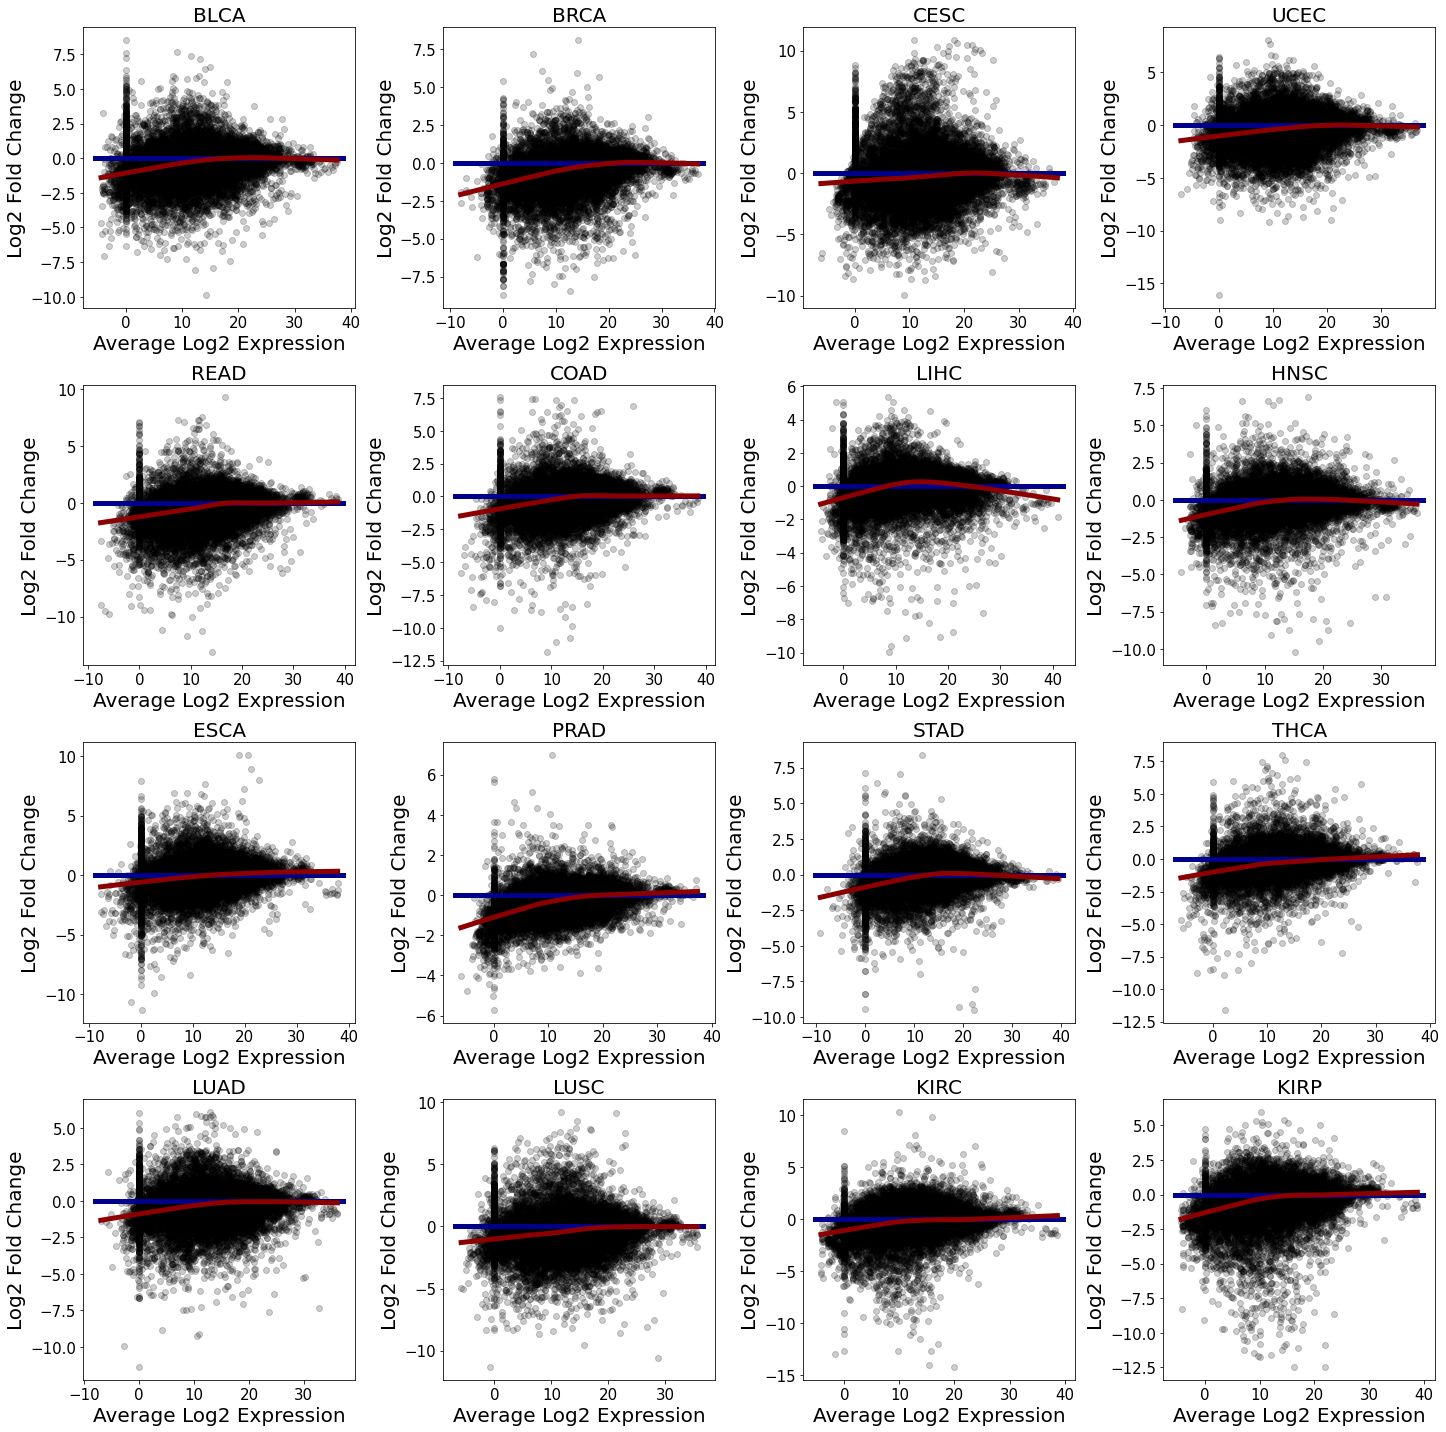

In [6]:
pc = pc_tcga
np.seterr(divide = 'ignore') 
from_barcode = pancancer._patient_id_from_barcode()
norm_sample = pancancer._norm_sample
fig = plt.figure(figsize=(20, 20))
for i in range(len(pc.fcs)):
    tissue_name = pc.tissue_types[i]
    tumor_ge = pc.tumors_fpkm[i]
    normal_ge = pc.normals_fpkm[i]
    # compute fold changes between same patient cancer vs. normal
    samples_to_use = [i for i in tumor_ge.columns if from_barcode(i) in normal_ge.columns.map(from_barcode)]
    fc_patients = tumor_ge[samples_to_use].apply(lambda col: norm_sample(col, normal_ge))
    #assert ((fc_patients.columns == samples_to_use).all())
    
    # compute M/A values
    M = np.log2(fc_patients.median(axis=1))
    A = np.log2(tumor_ge[samples_to_use].apply(lambda col: pancancer.get_a_values(col, normal_ge)).median(axis=1)).replace([-np.inf, np.inf], 0)
    
    plt.subplot(4, 4, i+1)
    plt.plot([A.min()-1, A.max()+1], [0, 0], lw=5, color='darkblue')
    g = sns.regplot(x=A, y=M, fit_reg=True, ci=None,
                    color='black',
                    scatter_kws={'alpha': 0.2},
                    lowess=True, line_kws={'lw': 5, 'color': 'darkred'}
                   )
    g.set_xlabel('Average Log2 Expression', fontsize=20)
    g.set_ylabel('Log2 Fold Change', fontsize=20)
    g.set_title(tissue_name[1].upper(), fontsize=20)
    g.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
# fig.savefig('../../data/pancancer/TCGA/expression/ma_plot_tumor_vs_tcga_countnorm_all.png', dpi=150)

In [ ]:
def plus(a, b):
    return a + b